### Importing Libraries

In [12]:
import copy
import glob
import sys
import os
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import plot_confusion_matrix
import timm
from timm.data import create_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.models import resnet101, mobilenet_v2
from tqdm.notebook import tqdm
import torchvision
import wandb
from ulid import ULID


from robust_optimization import RobustOptimizer

print(f'Torch: {torch.__version__}')
print(f'Timm: {timm.__version__}')




Torch: 1.9.0+cu111
Timm: 0.4.5


### Select Network and Dataset

In [13]:
chooseModels = {
    "efficientNet": "efficientnet_b0",
    "vgg19": "vgg19",
    "efficientNet2":"efficientnet_b2"
}
chooseDatasets = {
    "downScaled affecnet-folder": "downScaled_folder_name",
    "downScaled affecnet-label": "downScaled_label_name",
    "highRes affecnet-folder": "kaggle_highresAffecnet",
    "FER":"FER"
}
chooseLoss = {
    "weighted": "weightedLoss",
    "arcface":"arcface"
}
chooseMLP = {
    1:1,
    2:2,
    3:3
}


backbone = chooseModels["efficientNet2"]
dataset_used = chooseDatasets["highRes affecnet-folder"]
loss_used = chooseLoss["weighted"]
MLP_used = chooseMLP[1]


# CHANGE IF DIRECTORY NAMES ARE DIFFERENT
lowResData = "./DownScaledAffectNet/"
highResData = "./AffectNet/"
FerData = "./FER-2013/"

In [14]:
UNIQUE_RUN_ID = str(ULID().milliseconds)
wandb.init(project="252D_emotion_rec", entity='consolebot', name = f'./{dataset_used}_{backbone}_mlp{MLP_used}_{UNIQUE_RUN_ID}',   config={
    "backbone": backbone,
    "dataset_used": dataset_used,
    "loss_used": loss_used,
    "epochs": 10,
    })

In [15]:
def plot_loss(t_loss, v_loss):
    fname = f'./runs/{UNIQUE_RUN_ID}_loss_plot.png'
    
    epochs = range(1, len(t_loss) + 1)

    # Plot generator and discriminator losses
    plt.plot(epochs, t_loss, label='Train Loss')
    plt.plot(epochs, v_loss, label='Valid Loss')

    # Set plot labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Losses')

    # Add legend
    plt.legend()

    # Save the plot
    plt.savefig(fname)
    wandb.log({"loss_plot": wandb.Image(fname)})

    plt.close()

## Hyperparameters

In [16]:
batch_size = 16 #48# 32# 32 #16 #8 #
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


## Transforms on images

In [17]:
IMG_SIZE=260 if 'b2' in backbone else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
# print(test_transforms)

In [18]:
# num_workers = no of cpu cores - 1
kwargs = {'num_workers': 7, 'pin_memory': True} if use_cuda else {}

## Dataloader

In [19]:
if dataset_used == "downScaled_folder_name":
    affectnet_dir = lowResData
    class AffectNet(data.Dataset):
        def __init__(self, aff_path, mode, use_cache=True, transforms=None, force=False):
            self.mode = mode
            self.transforms = transforms
            self.aff_path = aff_path
            self.base_path = aff_path

            if mode == "train": 
                df = pd.read_csv('lowres_noise_train_labels.csv')
            elif mode == "test":
                df = pd.read_csv('lowres_noise_labels.csv')

            self.data = df 
            self.file_paths = self.data.loc[:, 'pth'].values
            self.label = self.data.loc[:, 'label'].values
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            self.dick = { 'neutral' :0 ,'happy' : 1, 'sad' :2 , 'surprise':3, 'fear':4, 'disgust':5, 'anger':6, 'contempt':7}
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print(f'\n{len(self)} images')


        def get_weight(self):
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            self.class_to_idx = {}
            self.idx_to_class = {}
            for i, emotion in enumerate(self.emotion_labels):
                self.class_to_idx[emotion] = i
                self.idx_to_class[i] = emotion
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print('')

            cw = 1/sample_counts
            cw /= cw.min()
            class_weights = {self.dick[i.lower()]:cwi for i, cwi in zip(sample_label, cw)}
            print(class_weights)
            return class_weights

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            path = os.path.join(self.base_path, self.file_paths[idx])
            image = Image.open(path).convert('RGB')
            label = self.label[idx]

            if self.transforms is not None:
                image = self.transforms(image)

            return image, self.dick[label]

elif dataset_used == "downScaled_label_name":
    affectnet_dir = lowResData
    class AffectNet(data.Dataset):
        def __init__(self, aff_path, mode, use_cache=True, transforms=None, force=False):
            self.mode = mode
            self.transforms = transforms
            self.aff_path = aff_path
            self.base_path = aff_path

            if mode == "train": 
                df = pd.read_csv('lowres_noiseFree_train_labels.csv')
            elif mode == "test":
                df = pd.read_csv('lowres_noiseFree_test_labels.csv')

            self.data = df 
            self.file_paths = self.data.loc[:, 'pth'].values
            self.label = self.data.loc[:, 'label'].values
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            self.dick = { 'neutral' :0 ,'happy' : 1, 'sad' :2 , 'surprise':3, 'fear':4, 'disgust':5, 'anger':6, 'contempt':7}
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print(f'\n{len(self)} images')


        def get_weight(self):
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            self.class_to_idx = {}
            self.idx_to_class = {}
            for i, emotion in enumerate(self.emotion_labels):
                self.class_to_idx[emotion] = i
                self.idx_to_class[i] = emotion
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print('')

            cw = 1/sample_counts
            cw /= cw.min()
            class_weights = {self.dick[i.lower()]:cwi for i, cwi in zip(sample_label, cw)}
            print(class_weights)
            return class_weights

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            path = os.path.join(self.base_path, self.file_paths[idx])
            image = Image.open(path).convert('RGB')
            label = self.label[idx]

            if self.transforms is not None:
                image = self.transforms(image)

            return image, self.dick[label]

elif dataset_used == "kaggle_highresAffecnet":
    affectnet_dir = highResData
    class AffectNet(data.Dataset):
        def __init__(self, aff_path, mode, use_cache=True, transforms=None, force=False):
            self.mode = mode
            self.transforms = transforms
            self.aff_path = aff_path
            self.base_path = aff_path

            if mode == "train": 
                df = pd.read_csv('highRes_train_labels.csv')
            elif mode == "test":
                df = pd.read_csv('highRes_test_labels.csv')

            self.data = df 
            self.file_paths = self.data.loc[:, 'pth'].values
            self.label = self.data.loc[:, 'label'].values
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            self.dick = { 'neutral' :0 ,'happy' : 1, 'sad' :2 , 'surprise':3, 'fear':4, 'disgust':5, 'anger':6, 'contempt':7}
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print(f'\n{len(self)} images')


        def get_weight(self):
            self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
            self.class_to_idx = {}
            self.idx_to_class = {}
            for i, emotion in enumerate(self.emotion_labels):
                self.class_to_idx[emotion] = i
                self.idx_to_class[i] = emotion
            sample_label, sample_counts = np.unique(self.label, return_counts=True)
            for l, c in zip(sample_label, sample_counts):
                print(f'{self.emotion_labels[self.dick[l.lower()]]}: {c} ', end='')
            print('')

            cw = 1/sample_counts
            cw /= cw.min()
            class_weights = {self.dick[i.lower()]:cwi for i, cwi in zip(sample_label, cw)}
            print(class_weights)
            return class_weights

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            yo = self.file_paths[idx]
    #         yo = yo[12:]
    #         print("yo")
            path = os.path.join(self.base_path, yo[2:])
    #         print(path,"path")
    #         print("\n")
    #         print("base",self.base_path)
    #         print("\n")
    #         print("file",self.file_paths[idx])
    #         print("\n")
    #         assert 1!=1
            image = Image.open(path).convert('RGB')
            label = self.label[idx]

            if self.transforms is not None:
                image = self.transforms(image)

            return image, self.dick[label]
elif dataset_used == "FER":
    affectnet_dir = FerData
    trainset = create_dataset(name='', root='./Data_FER/train', transform=train_transforms)
    valset = create_dataset(name='', root='./Data_FER/test', transform=test_transforms)
else:
    import sys
    sys.exit("Dataset not Defined!!!")


In [20]:
if dataset_used != "FER":
    trainset = AffectNet(affectnet_dir, 'train', transforms=train_transforms, force=False)
    valset = AffectNet(affectnet_dir, 'test', transforms=test_transforms)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
valloader = data.DataLoader(valset, batch_size=batch_size, shuffle=False, **kwargs)

Anger: 3200 Contempt: 3000 Disgust: 3042 Fear: 3200 Happiness: 3200 Neutral: 3200 Sadness: 3200 Surprise: 3200 
25242 images
Anger: 800 Contempt: 750 Disgust: 761 Fear: 800 Happiness: 800 Neutral: 800 Sadness: 800 Surprise: 800 
6311 images


In [21]:
if dataset_used != "FER":
    class_weights = trainset.get_weight()

Anger: 3200 Contempt: 3000 Disgust: 3042 Fear: 3200 Happiness: 3200 Neutral: 3200 Sadness: 3200 Surprise: 3200 
{6: 1.0, 7: 1.0666666666666667, 5: 1.051939513477975, 4: 1.0, 1: 1.0, 0: 1.0, 2: 1.0, 3: 1.0}


In [22]:
#from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

## Loss functions

### Weighted Loss

In [23]:
# loss function
def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device

device = get_device()
print("runing on ", device)
if dataset_used != "FER":
    weights = torch.FloatTensor(list(class_weights.values())).to(device)

def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # convert to one-hot
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    #logsoftmax = nn.LogSoftmax(dim=-1)
    return torch.mean(torch.sum(- weights*soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1)) #num_classes) #
    return cross_entropy_loss_with_soft_target(pred, soft_target)

if dataset_used != "FER":
    criterion=cross_entropy_with_label_smoothing
else:
    criterion = nn.CrossEntropyLoss()

runing on  cuda


### Arcface Loss

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size)).to(device)
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
#         self.W = self.W.to(device)
#         print(embeddings.device,self.W.device,"yo")
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale

In [25]:
arcface = ArcFaceLoss(
                num_classes=8, 
                embedding_size=8,
                margin=0.3, 
                scale=30.0)

## Training loop

In [26]:
def train(model,n_epochs=100, learningrate=lr, robust=False):
    # optimizer

    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(trainloader):
            
            data = data.to(device)
#             print("data",data.shape)
            label = label.to(device)

            output = model(data)
            
#             print(output.device)
#             print(label.device)
            
            if loss_used == "arcface":
                loss = arcface(output, label)
            else:
                loss = criterion(output, label)

            if robust:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                output = output.to(device)
                if loss_used == "arcface":
                    loss = arcface(output, label)
                else:
                    loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_accuracy += acc
            epoch_loss += loss
        epoch_accuracy /= len(trainset)
        epoch_loss /= len(trainset)
        
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valloader:
                data = data.to(device)
                label = label.to(device)
#                 val_output = val_output.to(device)

                val_output = model(data)
                if loss_used == "arcface":
                    val_loss = arcface(val_output, label)
                else:
                    val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(valset)
        epoch_val_loss /= len(valset)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        
        wandb.log({'epoch': epoch+1, 'Train Loss': epoch_loss, 'Validation Loss': epoch_val_loss, 'Validation Accuracy': epoch_val_accuracy})
        train_lossi.append(epoch_loss.item())
        val_lossi.append(epoch_val_loss.item())
        
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valloader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                if loss_used == "arcface":
                    val_loss = arcface(val_output, label)
                else:
                    val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(valset)
        epoch_val_loss /= len(valset)
        print(
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")
    
    plot_loss(train_lossi, val_lossi)

### Creating the model

In [27]:
if backbone == "vgg19":
    model = torchvision.models.vgg19(pretrained=True)
    in_feat = 25088
    
elif backbone == "efficientnet_b0":
    model = timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
    model.classifier=torch.nn.Identity()
    model.load_state_dict(torch.load('./state_vggface2_enet0_new.pt', map_location=torch.device(device))) #_new
    in_feat = 1280 
elif backbone == "efficientnet_b2":
    model = timm.create_model('tf_efficientnet_b2_ns', pretrained=False)
    model.classifier=torch.nn.Identity()
    model.load_state_dict(torch.load('./state_vggface2_enet2.pt', map_location=torch.device(device))) #_new
    in_feat = 1408 
else:
    import sys
    sys.exit("INVALID model,, NOT IMPLEMENTED")

In [28]:
if dataset_used != "FER":
    num_classes = len(trainset.emotion_labels)
else:
    num_classes = 8

if backbone == "vgg19":
    if MLP_used == 3:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=10000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=10000, out_features=1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1000, out_features=num_classes)
        )
    elif MLP_used == 2:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=10000),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=10000, out_features=num_classes),
        )
    elif MLP_used == 1:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=num_classes),
        )
    else:
        import sys
        sys.exit("INVALID number of layers in MLP,, NOT IMPLEMENTED")

       
    
if backbone == "efficientnet_b0":
    if MLP_used == 3:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    elif MLP_used == 2:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=640),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=640, out_features=num_classes)
        )
    elif MLP_used == 1:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=num_classes),
        )
if backbone == "efficientnet_b2":
    if MLP_used == 3:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=num_classes)
        )
    elif MLP_used == 2:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=640),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=640, out_features=num_classes)
        )
    elif MLP_used == 1:
        model.classifier = nn.Sequential(
            nn.Linear(in_features=in_feat, out_features=num_classes),
        )
    else:
        import sys
        sys.exit("INVALID number of layers in MLP,, NOT IMPLEMENTED")
    


#model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
#model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(


### Training only classifier

In [29]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)

robust = True
if backbone == "vgg19":
    robust = False
    
train_lossi = []
val_lossi = []


train(model,3,0.001,robust=robust)

  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch : 1 - loss : 0.1185 - acc: 0.3289 - val_loss : 0.1055 - val_acc: 0.4489



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 2 - loss : 0.1123 - acc: 0.3823 - val_loss : 0.1029 - val_acc: 0.4543



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 3 - loss : 0.1104 - acc: 0.4020 - val_loss : 0.1032 - val_acc: 0.4595

Best acc:0.45951512455940247


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


val_loss : 0.1032 - val_acc: 0.4595



### Training the entire model

In [30]:
set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,robust=robust)

  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 1 - loss : 0.0996 - acc: 0.4707 - val_loss : 0.0867 - val_acc: 0.5749



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 2 - loss : 0.0885 - acc: 0.5532 - val_loss : 0.0851 - val_acc: 0.5766



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 3 - loss : 0.0820 - acc: 0.6078 - val_loss : 0.0856 - val_acc: 0.5837



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 4 - loss : 0.0756 - acc: 0.6605 - val_loss : 0.0869 - val_acc: 0.5784



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 5 - loss : 0.0691 - acc: 0.7133 - val_loss : 0.0886 - val_acc: 0.5700



  0%|          | 0/1578 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

Epoch : 6 - loss : 0.0627 - acc: 0.7715 - val_loss : 0.0916 - val_acc: 0.5722

Best acc:0.5837426781654358


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


val_loss : 0.0856 - val_acc: 0.5837



In [31]:
# Save
PATH = f'./{dataset_used}_{backbone}_mlp{MLP_used}.pt'
torch.save(model, PATH)

## Testing

In [32]:
def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device
device = get_device()
PATH = f'./{dataset_used}_{backbone}_mlp{MLP_used}.pt'
print(PATH)
model = torch.load(PATH,map_location=torch.device(device))
model = model.eval()

./kaggle_highresAffecnet_efficientnet_b2_mlp1.pt


In [33]:
if dataset_used != "FER":
    class_to_idx = trainset.class_to_idx
    print(class_to_idx)
    idx_to_class = trainset.idx_to_class
    print(idx_to_class)

{'Neutral': 0, 'Happiness': 1, 'Sadness': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}
{0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}


In [34]:
y_val,y_scores_val=[],[]
model.eval()

for image, label in valloader:
#     image.unsqueeze_(0)
    image = image.to(device)
    scores = model(image)
    
    for i in range(len(scores)):
        score = scores[i].data.cpu().numpy()
        y_scores_val.append(score)
        y_val.append(label[i])

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


(6311, 8) (6311,)


In [35]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

# y_train=np.array(trainset.label)

# for i in range(y_scores_val.shape[1]):
#     _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
#     print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

58.37426715259071


### Confusion Matrix

['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
(6311,) (6311,) 0.5837426715259072


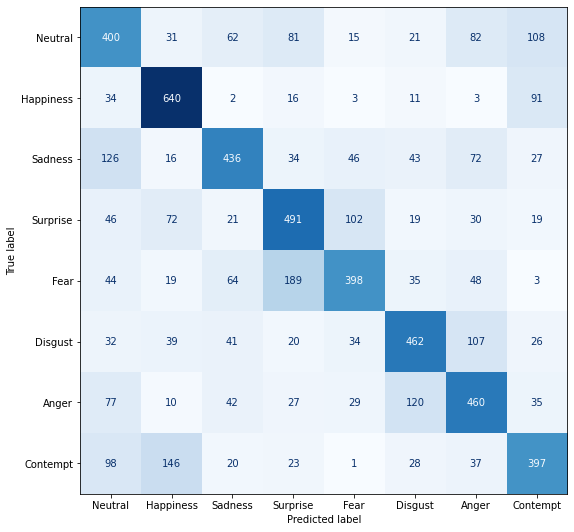

In [36]:
if dataset_used != "FER":
    labels=list(class_to_idx.keys())
    print(labels)
    IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
    def plt_conf_matrix(y_true,y_pred,labels):
        print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

        fig, ax = plt.subplots(figsize=(8, 8))
        plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False) #,normalize='true'
        plt.tight_layout()
        plt.show()
    plt_conf_matrix(y_val,y_pred,labels)

## Number of parameters in the model

In [37]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

7712266

In [ ]:
wandb.finish()